# Q1. Frequency mixer: ‘Beauty and the Blur’

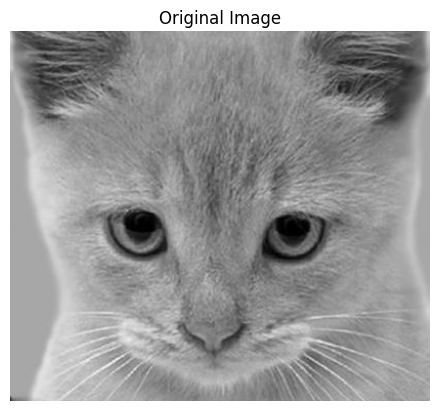

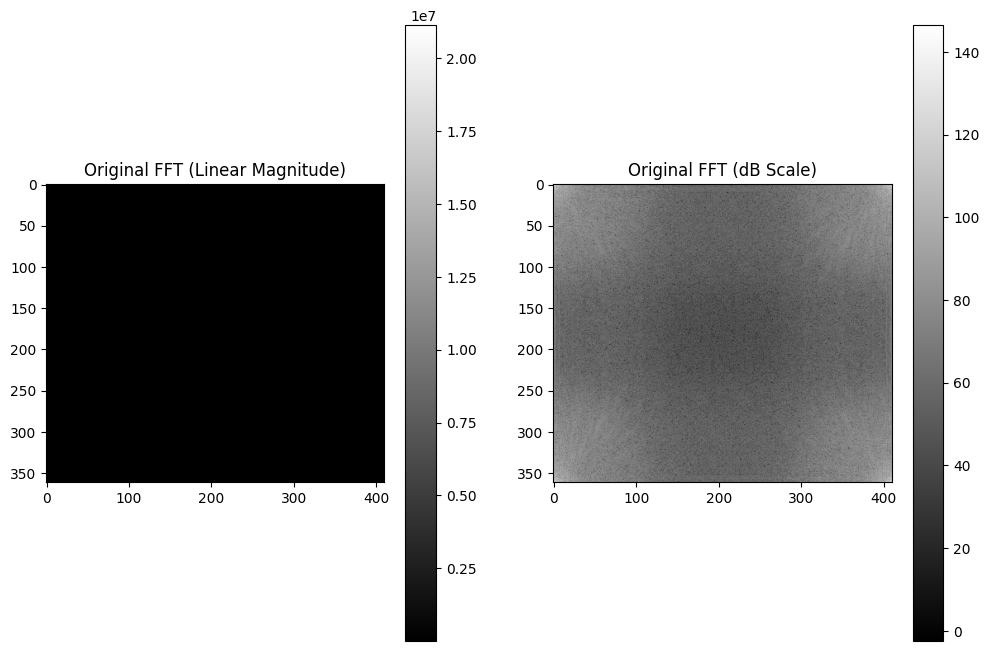

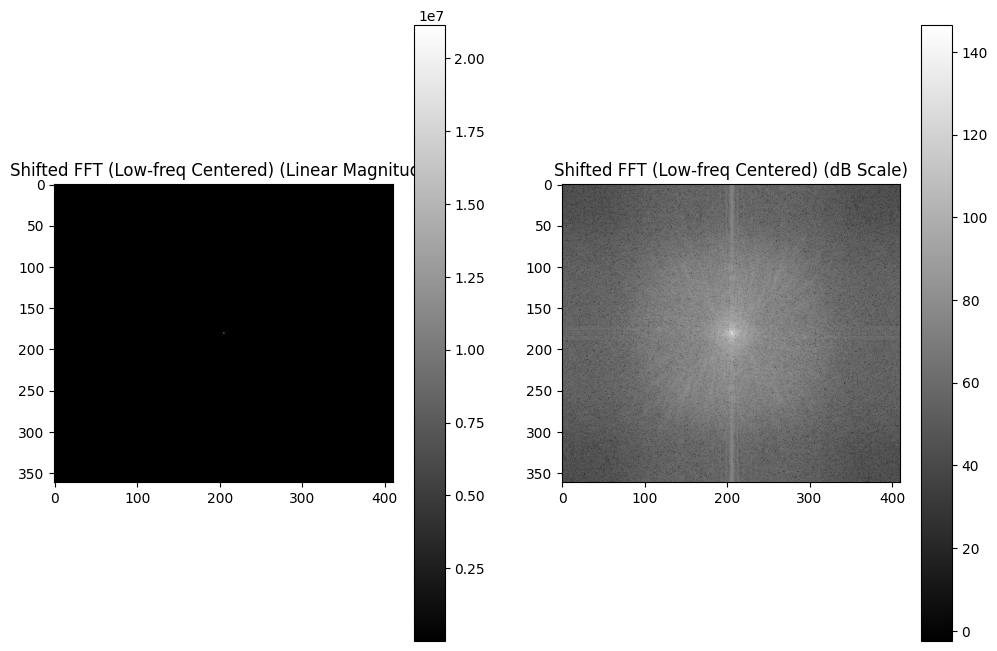

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Helper function to plot spectrum
def plot_spectrum(F, title="Spectrum"):
    magnitude = np.abs(F)
    spectrum_db = 20 * np.log10(magnitude + 1e-5)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap='gray')
    plt.title(f"{title} (Linear Magnitude)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(spectrum_db, cmap='gray')
    plt.title(f"{title} (dB Scale)")
    plt.colorbar()
    plt.show()


img_pil = Image.open("cat_gray.jpg").convert("L")
img = np.array(img_pil)

# Show original image
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# 2D FFT
F = np.fft.fft2(img)
plot_spectrum(F, title="Original FFT")

# Shift to center
F_shifted = np.fft.fftshift(F)
plot_spectrum(F_shifted, title="Shifted FFT (Low-freq Centered)")

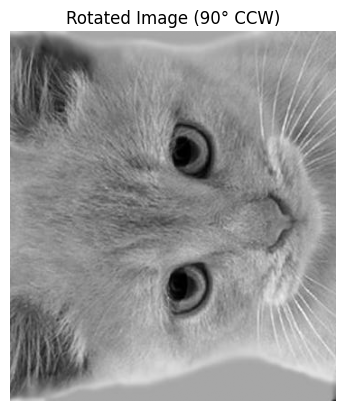

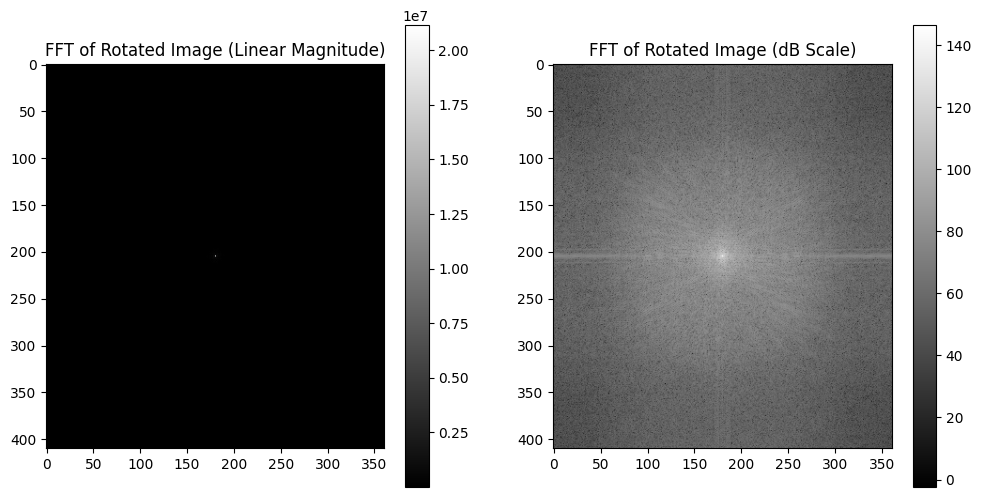

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and convert image to grayscale
img = np.array(Image.open("cat_gray.jpg").convert("L"))

# Rotate image by 90 degrees counter-clockwise
img_rotated = np.rot90(img, k=1)

# FFT of rotated image
F_rot = np.fft.fft2(img_rotated)
F_rot_shifted = np.fft.fftshift(F_rot)

# Helper function
def plot_spectrum(F, title="Spectrum", filename=None):
    magnitude = np.abs(F)
    spectrum_db = 20 * np.log10(magnitude + 1e-5)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap='gray')
    plt.title(f"{title} (Linear Magnitude)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(spectrum_db, cmap='gray')
    plt.title(f"{title} (dB Scale)")
    plt.colorbar()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Show rotated image
plt.imshow(img_rotated, cmap='gray')
plt.title("Rotated Image (90° CCW)")
plt.axis('off')
plt.savefig("rotated_image.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot spectrum of rotated image
plot_spectrum(F_rot_shifted, title="FFT of Rotated Image", filename="rotated_fft.png")


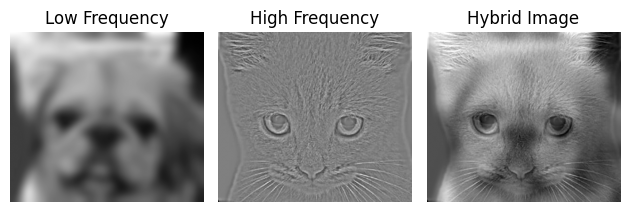

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.lib.stride_tricks import as_strided

# Load grayscale images using Pillow
img1 = np.array(Image.open("dog_gray.jpg").convert("L"), dtype=np.float32)
img2 = np.array(Image.open("cat_gray.jpg").convert("L"), dtype=np.float32)

# Helper function: Create a 2D Gaussian kernel
def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# Helper function: Apply convolution
def convolve2d(image, kernel):
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    out = np.zeros_like(image)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kernel)
    return out

# LOW FREQUENCY (from img1)
gaussian_kernel_low = gaussian_kernel(31, 10)
low_freq = convolve2d(img1, gaussian_kernel_low)

# HIGH FREQUENCY (from img2)
gaussian_kernel_high = gaussian_kernel(15, 5)
blurred = convolve2d(img2, gaussian_kernel_high)
high_freq = img2 - blurred

# Hybrid image = low + high
hybrid = low_freq + high_freq
hybrid = np.clip(hybrid, 0, 255).astype(np.uint8)

# Convert parts to displayable format
low_freq_display = np.clip(low_freq, 0, 255).astype(np.uint8)
high_freq_display = np.clip(high_freq + 127, 0, 255).astype(np.uint8)  # shift for visualization

# Plot
plt.subplot(1, 3, 1)
plt.imshow(low_freq_display, cmap='gray')
plt.title("Low Frequency")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(high_freq_display, cmap='gray')
plt.title("High Frequency")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hybrid, cmap='gray')
plt.title("Hybrid Image")
plt.axis('off')

plt.tight_layout()
plt.show()


# Q2. Frequency de-mixer: ‘Unwanted Solo’

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal as signal
import soundfile as sf


audio_path = 'song_with_2piccolo.wav'
y, sr = librosa.load(audio_path, sr=None)

print(f"Sample Rate: {sr} Hz")
print(f"Duration: {len(y)/sr:.2f} seconds")

# Normalize audio
y_normalized = y / np.max(np.abs(y))



Sample Rate: 48000 Hz
Duration: 15.00 seconds


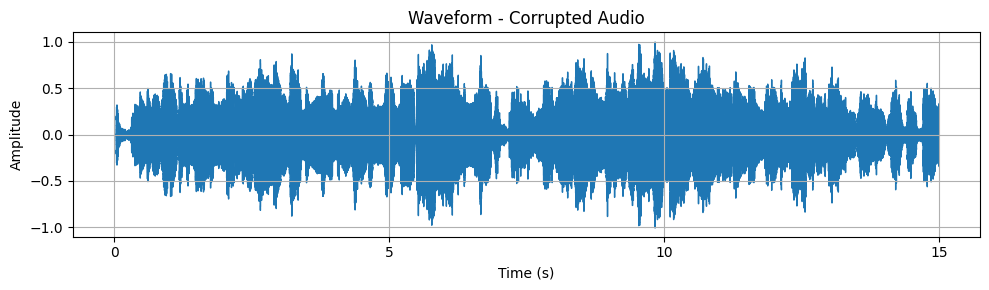

In [ ]:
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y_normalized, sr=sr)
plt.title("Waveform - Corrupted Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

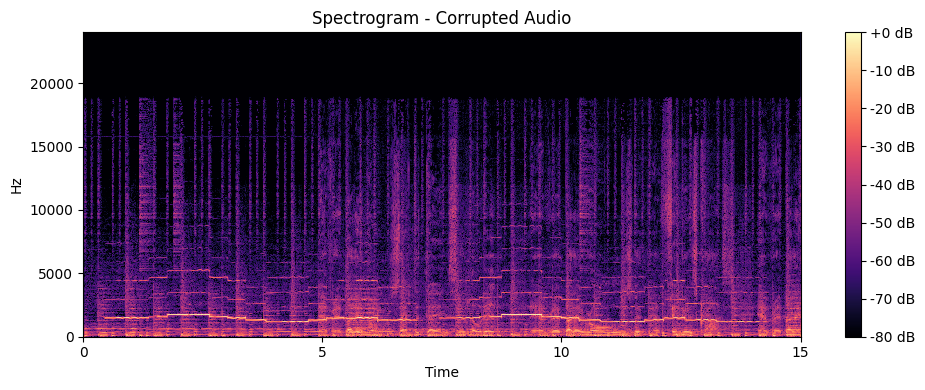

In [ ]:
# Spectrogram

D = librosa.stft(y_normalized)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram - Corrupted Audio")
plt.tight_layout()
plt.show()


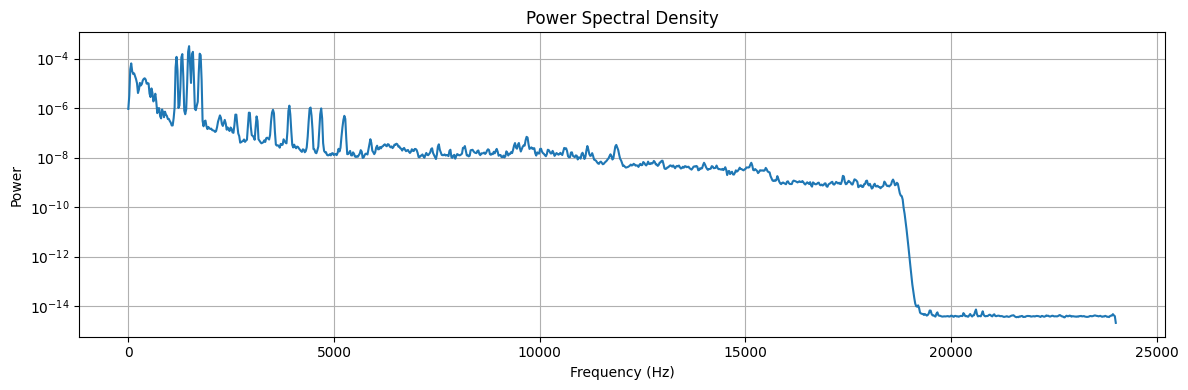

In [ ]:
# Power Spectral Density (PSD)

frequencies, power = signal.welch(y_normalized, fs=sr, nperseg=2048)

plt.figure(figsize=(12, 4))
plt.semilogy(frequencies, power)
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

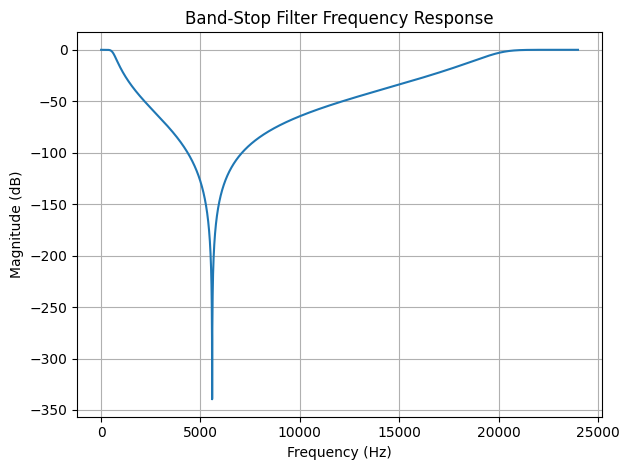

In [ ]:
# Step 5: Band-Stop Filter Design

lowcut = 600
highcut = 20000
nyq = sr / 2

low = lowcut / nyq
high = highcut / nyq

b, a = signal.butter(4, [low, high], btype='bandstop')

# Frequency response (Bode Plot)
w, h = signal.freqz(b, a, worN=8000, fs=sr)
plt.figure()
plt.plot(w, 20 * np.log10(abs(h)))
plt.title("Band-Stop Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

filtered_y = signal.filtfilt(b, a, y_normalized)


sf.write("restored_audio.wav", filtered_y, sr)
print(" Restored audio saved as 'restored_audio.wav'")

 Restored audio saved as 'restored_audio.wav'


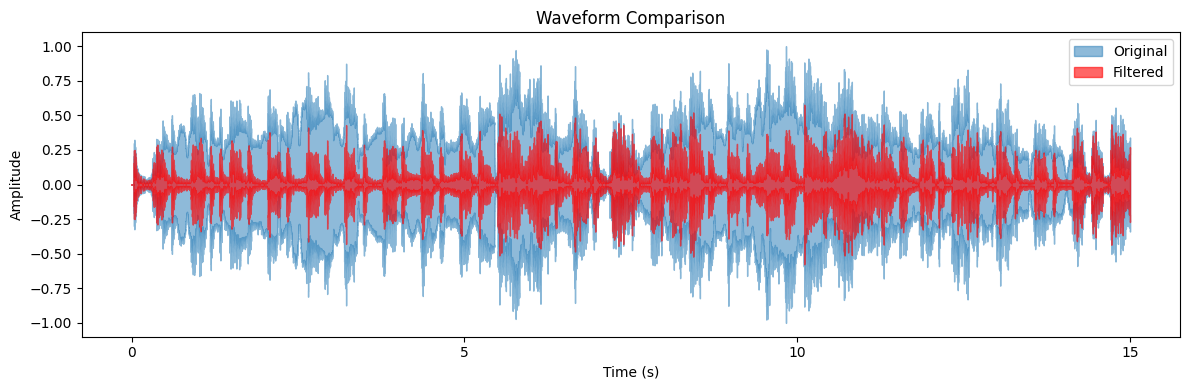

In [ ]:
# Original vs Filtered Waveform

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_normalized, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(filtered_y, sr=sr, color='r', alpha=0.6, label='Filtered')
plt.title("Waveform Comparison")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


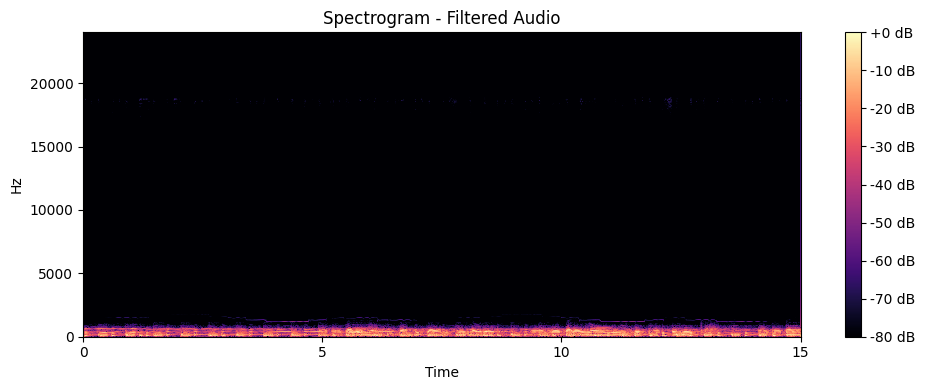

In [ ]:
# Step 9: Spectrogram of Filtered Audio

D_clean = librosa.stft(filtered_y)
S_db_clean = librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db_clean, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram - Filtered Audio")
plt.tight_layout()
plt.show()